In [15]:
# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [16]:
# Import the layer table which is where SMP data lives
from snowexsql.data import LayerData

# Import our convenient tool to convert to geopandas dataframes
from snowexsql.conversions import query_to_geopandas

# A little matplotlib biz if you want to plot multiple plots in a loop
import matplotlib.pyplot as plt 

# import geopandas lib to make a brand new GeoDataFrame to store your final results
import geopandas as gpd 

import pandas as pd
import numpy as np

Find some SMP filenames

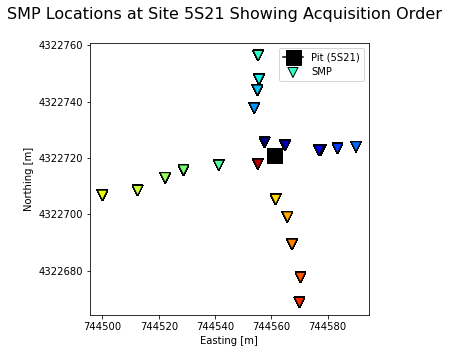

In [24]:
site = '5S21'
engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# Plot SMP profile locations with colored by the time they were taken using upside down triangles
ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# Add important labels
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# Avoid using Scientific notation for coords.
ax.ticklabel_format(style='plain', useOffset=False)
ax.legend()
# plt.tight_layout()
plt.show()

In [25]:
# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
34796,"fname = SNEX20_SMP_S19M0997_5S21_20200201.CSV,...",5.214860
27670,"fname = SNEX20_SMP_S19M0996_5S21_20200201.CSV,...",5.681141
2395,"fname = SNEX20_SMP_S19M1017_5S21_20200201.CSV,...",6.640878
52398,"fname = SNEX20_SMP_S19M1018_5S21_20200201.CSV,...",6.640878
30416,"fname = SNEX20_SMP_S19M1016_5S21_20200201.CSV,...",6.640878


Generate some data frames to store the data

In [44]:
final_df = gpd.GeoDataFrame(columns = ['siteID','med_force','geom','sum10','sum50'])
to_add_df = gpd.GeoDataFrame(columns = ['siteID','med_force','geom','sum10','sum50'])
#print(final_df)

Plot the raw data for one of the files

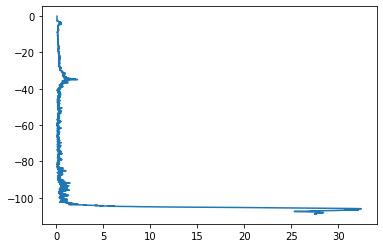

In [45]:
filenames = ['SMP_S19M0997_5S21_20200201.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

Manually input the snow surface and ground values

In [46]:
surface = -5
ground = -100

Find the median between the surface and ground, plot the filtered data, and add data to the data frame

0.237
35.491
399.728
  siteID  med_force                            geom   sum10    sum50
0   5S21      0.237  POINT (744564.879 4322724.486)  35.491  399.728


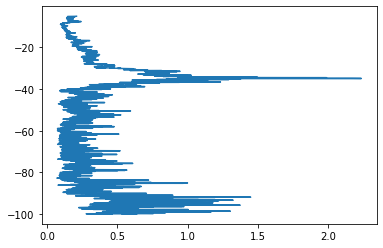

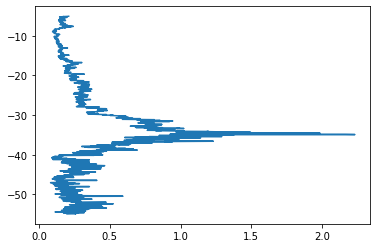

In [48]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

fig, axes = plt.subplots(1)
axes.plot(df[ind_50cm]['value'], df[ind_depth]['depth'])

# add median force and location to a dataframe
final_df['geom'] = df['geom'].unique() # Which should only be one location
final_df['med_force'] = df[ind]['value'].median()   
final_df['sum10'] = sum10
final_df['sum50'] = sum50
final_df['siteID'] = site
print(final_df)

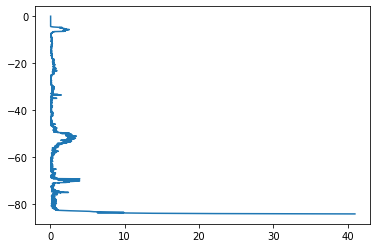

In [9]:
filenames = ['SNEX20_SMP_S19M0911_1S8_20200201.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

Manually input the snow surface and ground values

In [10]:
surface = -3
ground = -82

Find the median between the surface and ground, plot the filtered data, and store data to the data frame

0.26
998.0989999999999
   med_force                            geom
0       0.26  POINT (742606.052 4322880.455)


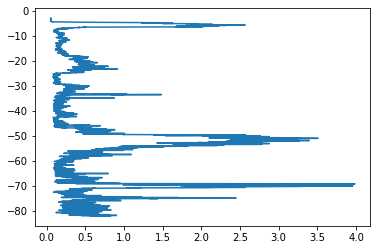

In [14]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)

# Print out a stat
median = df[ind]['value'].median()
sum = df[ind]['value'].sum()
print(median)
print(sum)

# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = median
print(to_add_df)

In [12]:
final_df = final_df.append(to_add_df)
print(final_df)

   med_force                            geom
0      0.158  POINT (743946.686 4322636.220)
0      0.260  POINT (742606.052 4322880.455)
